In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
import rl_utils
import random
import time

# TRPO (Discrete Action Space)

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.net(x)

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [3]:
class TRPO:
    """ TRPO algorithm """
    def __init__(self,
                 hidden_dim,
                 state_space,
                 action_space,
                 lmbda,
                 kl_constraint,
                 alpha,
                 critic_lr,
                 gamma,
                 device):
        
        self.gamma = gamma
        self.lmbda = lmbda # GAE parameter
        self.kl_constraint = kl_constraint # KL divergence distance
        self.alpha = alpha # line search parameter
        self.device = device

        state_dim = state_space.shape[0]
        action_dim = action_space.n
        
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device) # policy-net don't use torch.optim
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        action_dist = torch.distributions.Categorical(self.actor(state))
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        """ Compute Hessian matrix-vector product """
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists)) # compute KL divergence
        kl_grad = torch.autograd.grad(kl, self.actor.parameters(), create_graph=True)
        kl_grad_vector= torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector

    def conjugate_gradient(self, grad, states, old_action_dists):
        """ Solve the equation Hx = g using conjugate gradient """
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x
    
    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs, actor):
        """ Compute Policy Objective """
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs, old_action_dists, max_vec):
        """ Line search to find the step size """
        old_para = nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        
        for i in range(15):
            coef = self.alpha ** i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            nn.utils.convert_parameters.vector_to_parameters(new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(new_actor(states))
            kl_div = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para
    
    def policy_learn(self, states, actions, old_action_dists, old_log_probs, advantage):
        """ Update Policy Function """
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()

        # Solve x = H^(-1)g with conjugate gradient method
        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint / (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs, old_action_dists, descent_direction * max_coef)
        nn.utils.convert_parameters.vector_to_parameters(new_para, self.actor.parameters())
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_error = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_error.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        old_action_dists = torch.distributions.Categorical(self.actor(states).detach())

        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)

In [4]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 2e-1
kl_constraint = 0.0005
alpha = 0.7
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda, kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_249601/370052730.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392067780/work/torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:03<00:00, 13.99it/s, episode=500, return=200.000

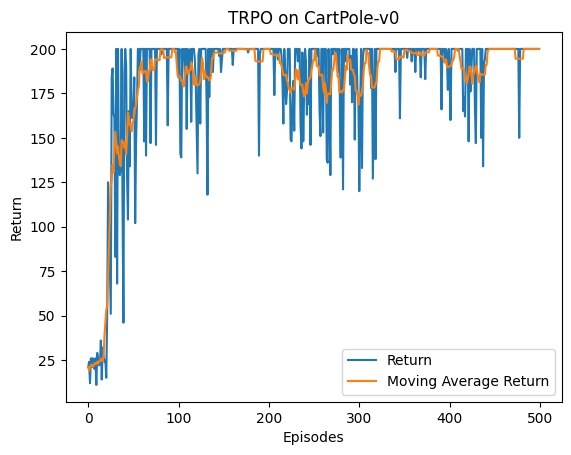

In [13]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, return_list, label='Return')
plt.plot(episodes_list, mv_return, label='Moving Average Return')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('TRPO on {}'.format(env_name))
plt.show()

In [10]:
test_env = gym.make(env_name, render_mode='human')
for episode in range(1):
    reset_output = test_env.reset()
    state = reset_output[0] if isinstance(reset_output, tuple) else reset_output
    done = False
    while not done:
        with torch.no_grad():
            action = agent.take_action(state)
    
        next_state, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        state = next_state
        
        time.sleep(0.02)

test_env.close()

In [14]:
rl_utils.watch_agent(env_name, agent, device, num_episodes=1)
# rl_utils.record_one_episode(env_name, agent, device, filename='TRPO_CartPole-v0')
# rl_utils.record_multiple_episodes(env_name, agent, device, num_episodes=10, videos_per_row=5, filename='TRPO_CartPole-v0-10r')

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [15]:
score = rl_utils.moving_average_score(return_list, 10)
print(score)

200.0


In [ ]:
agent_dict = {
    'actor': agent.actor,
    'critic': agent.critic
}

rl_utils.save_all(agent_dict=agent_dict,
                  return_list=return_list,
                  model_name='trpo_cartpole(v0)',
                  mv_return=mv_return,
                  score=score)

✅ Multi-agents saved at ./agent/trpo_cartpole(v0)_score200.00_20250430-004157.pth
📝 Save log updated at ./agent/save_log.json
✅ Return list saved at ./results/trpo_cartpole(v0)_score200.00_20250430-004157_return_list.pkl
📈 Return curve saved at ./results/trpo_cartpole(v0)_score200.00_20250430-004157_return_curve.png


In [7]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 2e-1
kl_constraint = 0.0005
alpha = 0.7
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda, kl_constraint, alpha, critic_lr, gamma, device)
agent_dict = {
    'actor': agent.actor,
    'critic': agent.critic
}

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [11]:
agent_dict, return_list = rl_utils.load_all(agent_dict=agent_dict,
                                            model_name='trpo_cartpole(v0)',
                                            timestamp='20250430-004157',
                                            score=200,
                                            device=device)

🔄 Multi-agents loaded from ./agent/trpo_cartpole(v0)_score200.00_20250430-004157.pth
🔄 Return list loaded from ./results/trpo_cartpole(v0)_score200.00_20250430-004157_return_list.pkl
📈 Return curve image available at ./results/trpo_cartpole(v0)_score200.00_20250430-004157_return_curve.png


# TRPO (Continuous Action Space)

In [7]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [10]:
class TRPOContinuous:
    """ TRPO algorithm for continuous action space """
    def __init__(self,
                 hidden_dim,
                 state_space,
                 action_space,
                 lmbda,
                 kl_constraint,
                 alpha,
                 critic_lr,
                 gamma,
                 device):
        
        self.gamma = gamma
        self.lmbda = lmbda
        self.kl_constraint = kl_constraint
        self.alpha = alpha
        self.device = device

        state_dim = state_space.shape[0]
        action_dim = action_space.shape[0]

        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()
        return [action.item()]
    
    def hessian_matrix_vector_product(self,
                                      states,
                                      old_action_dists,
                                      vector,
                                      damping=0.1):
        """ Compute Hessian matrix-vector product """
        mu, std = self.actor(states)
        new_action_dists = torch.distributions.Normal(mu, std)
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))
        kl_grad = torch.autograd.grad(kl, self.actor.parameters(), create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.contiguous().view(-1) for grad in grad2])
        return grad2_vector + damping * vector
    
    def conjugate_gradient(self,
                           grad,
                           states,
                           old_action_dists):
        """ Solve the equation Hx = g using conjugate gradient """
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x
    
    def compute_surrogate_obj(self,
                              states,
                              actions,
                              advantage,
                              old_log_probs,
                              actor):
        """ Compute Policy Objective """
        mu, std = actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self,
                    states,
                    actions,
                    advantage,
                    old_log_probs,
                    old_action_dists,
                    max_vec):
        """ Line search to find the step size """
        old_para = nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)

        for i in range(15):
            coef = self.alpha ** i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            nn.utils.convert_parameters.vector_to_parameters(new_para, new_actor.parameters())
            mu, std = new_actor(states)
            new_action_dists = torch.distributions.Normal(mu, std)
            kl_div = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, new_actor)

            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para
    
    def policy_learn(self,
                     states,
                     actions,
                     old_action_dists,
                     old_log_probs,
                     advantage):
        """ Update Policy Function """
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()

        # Solve x = H^(-1)g with conjugate gradient method
        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint / (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs, old_action_dists, descent_direction * max_coef)
        nn.utils.convert_parameters.vector_to_parameters(new_para, self.actor.parameters())
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        rewards = (rewards + 8.0) / 8.0
        td_target = rewards + self.gamma * self.critic(next_states) * (~dones.bool()).float()
        td_error = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_error.cpu()).to(self.device)
        mu, std = self.actor(states)
        old_action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        old_log_probs = old_action_dists.log_prob(actions)
        
        critic_loss = F.mse_loss(self.critic(states), td_target.detach())
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)

In [21]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.00005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

agent = TRPOContinuous(hidden_dim,
                       env.observation_space,
                       env.action_space,
                       lmbda,
                       kl_constraint,
                       alpha,
                       critic_lr,
                       gamma,
                       device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 200/200 [00:14<00:00, 14.05it/s, episode=2000, return=-523.255]


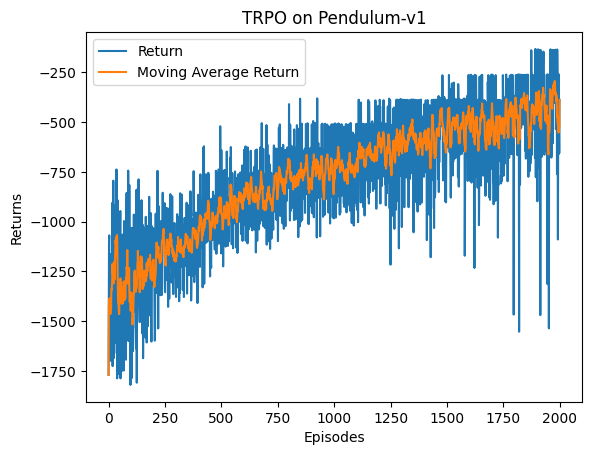

In [22]:
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(return_list, label='Return')
plt.plot(mv_return, label='Moving Average Return')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

In [23]:
rl_utils.watch_agent(env_name, agent, device, num_episodes=1)

/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [25]:
score = rl_utils.moving_average_score(return_list, 10)
print(score)

-523.2553176193464


In [26]:
agent_dict = {
    'actor': agent.actor,
    'critic': agent.critic
}
rl_utils.save_all(agent_dict=agent_dict,
                  return_list=return_list,
                  model_name='trpo_pendulum(v1)',
                  mv_return=mv_return,
                  score=score)

✅ Multi-agents saved at ./agent/trpo_pendulum(v1)_score-523.26_20250430-220744.pth
📝 Save log updated at ./agent/save_log.json
✅ Return list saved at ./results/trpo_pendulum(v1)_score-523.26_20250430-220744_return_list.pkl
📈 Return curve saved at ./results/trpo_pendulum(v1)_score-523.26_20250430-220744_return_curve.png


In [28]:
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=1,
                                  videos_per_row=1,
                                  filename='trpo_pendulum(v1)-1r',
                                  score=score)
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=10,
                                  videos_per_row=5,
                                  filename='trpo_pendulum(v1)-10r',
                                  score=score)

/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building file ./video/trpo_pendulum(v1)-1r_score-523.26_20250430-221101.gif with imageio.


✅ Video saved at ./video/trpo_pendulum(v1)-1r_score-523.26_20250430-221101.gif
MoviePy - Building file ./video/trpo_pendulum(v1)-10r_score-523.26_20250430-221105.gif with imageio.


✅ Video saved at ./video/trpo_pendulum(v1)-10r_score-523.26_20250430-221105.gif
